In [99]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Embedding, BatchNormalization, Dropout
import seaborn as sns
from sklearn import metrics
import ast
from nltk import wordpunct_tokenize
import re

# **Get data**

In [34]:
movie_train_path = 'cleaned_data\movies_train_augmented.csv'
movie_test_path = 'cleaned_data\movies_test.csv'
genre_path = 'cleaned_data\genres.txt'

In [35]:
movies_train = pd.read_csv(movie_train_path, engine= 'python',
                         encoding='latin-1', index_col=False)
movies_test = pd.read_csv(movie_test_path, engine='python',
                         encoding='latin-1', index_col=False)

In [36]:
movies_train['genre'] = movies_train['genre'].apply(ast.literal_eval)
movies_test['genre'] = movies_test['genre'].apply(ast.literal_eval)


In [37]:
movies_train

,movieid,title,genre
0,1650,Washington Square,[Drama]
1,185,The Net,"[Sci-Fi, Thriller]"
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]"
3,3204,The Boys from Brazil,[Thriller]
4,1901,Dear Jesse,[Documentary]
...,...,...,...
8776,1750,Adept,"[Adventure, Children's, Fantasy, Sci-Fi]"
8777,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]"
8778,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]"
8779,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]"


In [38]:
movies_test

,movieid,title,genre
0,3397,The Great Muppet Cape,"[Children's, Comedy]"
1,2067,Doctor Zhivag,"[Drama, Romance, War]"
2,2651,Frankenstein Meets the Wolf Ma,[Horror]
3,2989,For Your Eyes Onl,[Action]
4,3415,The Mirro,[Drama]
...,...,...,...
772,2309,The Inheritor,[Drama]
773,2421,Part II Karate Ki,"[Action, Adventure, Drama]"
774,3255,A League of Their Ow,"[Comedy, Drama]"
775,974,Algier,"[Drama, Romance]"


In [39]:
movies_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieid  777 non-null    int64 
 1   title    777 non-null    object
 2   genre    777 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.3+ KB


# **Train, test set**

In [40]:
with open(genre_path, 'r') as f:
    genre_all = f.readlines()
    genre_all = [x.replace('\n','') for x in genre_all]
genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}
idx2genre = {idx: genre for idx, genre in enumerate(genre_all)}
num_classes = len(genre2idx)
print(num_classes)
print(genre2idx)

18
{'Crime': 0, 'Thriller': 1, 'Fantasy': 2, 'Horror': 3, 'Sci-Fi': 4, 'Comedy': 5, 'Documentary': 6, 'Adventure': 7, 'Film-Noir': 8, 'Animation': 9, 'Romance': 10, 'Drama': 11, 'Western': 12, 'Musical': 13, 'Action': 14, 'Mystery': 15, 'War': 16, "Children's": 17}


In [41]:
idx2genre

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

In [42]:
def label_to_vecto(genre: list[str]):
    genre_vector = np.zeros(len(genre2idx))

    for g in genre:
        genre_vector[genre2idx[g]] = 1
    
    return genre_vector

In [43]:
type(movies_test.iloc[0]['genre'][0])

str

In [44]:
print(label_to_vecto(['Horror', 'Action', 'Drama', 'Romance', 'War']))

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.]


In [45]:
movies_train['vecto'] = movies_train['genre'].apply(label_to_vecto)
movies_test['vecto'] = movies_test['genre'].apply(label_to_vecto)

In [46]:
movies_train = movies_train.sample(frac=1).reset_index(drop=True)

In [47]:
movies_train

,movieid,title,genre,vecto
0,229,Death and the Maiden,"[Drama, Thriller]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3625,Done unrecorded fountainhead,[Documentary],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,3508,The Wheal,[Western],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,220,Castle Monstrosity,[Horror],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1928,Canadensis,[Western],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
8776,3045,Peter's Friends,"[Comedy, Drama]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
8777,1283,dozen eminent,[Western],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8778,900,An American in Paris,"[Musical, Romance]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8779,3090,Matewan,[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
movies_test

,movieid,title,genre,vecto
0,3397,The Great Muppet Cape,"[Children's, Comedy]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,2067,Doctor Zhivag,"[Drama, Romance, War]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2651,Frankenstein Meets the Wolf Ma,[Horror],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2989,For Your Eyes Onl,[Action],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3415,The Mirro,[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
772,2309,The Inheritor,[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
773,2421,Part II Karate Ki,"[Action, Adventure, Drama]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
774,3255,A League of Their Ow,"[Comedy, Drama]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
775,974,Algier,"[Drama, Romance]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [49]:
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    # tokens = tokens[:-1] # remove last token because it is the year which maybe is not useful
    return tokens

def create_vocab():
    df = movies_train.copy()
    arr_title = df['title'].tolist()
    vocab = set()
    for title in arr_title:
        tokens = tokenize(title)
        vocab.update(tokens)
    vocab = list(vocab)
    pad_token = '<PAD>'
    unk_token = '<UNK>'
    vocab.append(pad_token)
    vocab.append(unk_token)
    return vocab

In [50]:
vocab = create_vocab()
len_vocab = len(vocab)
print('length of vocab:', len_vocab)
print(tokenize('A Face in the Crowd'))

length of vocab: 5198
['a', 'face', 'in', 'the', 'crowd']


In [51]:
x_train = movies_train['title']
x_test = movies_test['title']

In [52]:
y_train = np.array(movies_train['genre'])
y_test = np.array(movies_test['genre'])
y_train = np.array(list(map(label_to_vecto, y_train)))
y_test = np.array(list(map(label_to_vecto, y_test)))

In [53]:
max_words = len_vocab
max_len = 7
tok = Tokenizer(num_words = max_words)

# fit_on_texts: tạo ra 1 từ vựng từ training_set với kích thước max_words
# texts_to_sequences: chuyển đổi mỗi từ trong câu thành 1 số nguyên dựa trên từ vựng
# pad_sequences: cắt bớt hoặc chèn thêm 0 vào mỗi vector từ để được kích thước max_len
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen = max_len, padding= 'post')

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len, padding= 'post')

In [54]:
sequences_matrix.shape, test_sequences_matrix.shape

((8781, 7), (777, 7))

In [55]:
x_test

0               The Great Muppet Cape
1                       Doctor Zhivag
2      Frankenstein Meets the Wolf Ma
3                   For Your Eyes Onl
4                           The Mirro
                    ...              
772                     The Inheritor
773                 Part II Karate Ki
774              A League of Their Ow
775                            Algier
776                      Baby Geniuse
Name: title, Length: 777, dtype: object

In [56]:
test_sequences_matrix

array([[   1,   73,  407, ...,    0,    0,    0],
       [2661,    0,    0, ...,    0,    0,    0],
       [ 123,    1,  196, ...,    0,    0,    0],
       ...,
       [   4, 2773,    2, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 396,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [57]:
y_train.shape, y_test.shape

((8781, 18), (777, 18))

In [58]:
movies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8781 entries, 0 to 8780
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieid  8781 non-null   int64 
 1   title    8781 non-null   object
 2   genre    8781 non-null   object
 3   vecto    8781 non-null   object
dtypes: int64(1), object(3)
memory usage: 274.5+ KB


In [59]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **Model**

In [60]:
model = Sequential([
    Embedding(len_vocab, 200),
    LSTM(100, activation='relu', return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='relu'),
    BatchNormalization(),
    Dropout(rate= 0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(rate= 0.1),
    Dense(18, activation='sigmoid')
])

In [61]:
# class BaseModel(nn.Module):
#     def __init__(self, num_classes, len_vocab, embedding_dimension=3898, hidden_size=64):
#         super(BaseModel, self).__init__()
#         self.hidden_size = hidden_size

#         # img
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.maxpool = nn.MaxPool2d(kernel_size=4, stride=4)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 64 * 64, hidden_size)


#         # text
#         self.fc2 = nn.Linear(7*len_vocab, hidden_size)

#         self.fc3 = nn.Linear(hidden_size*2, num_classes)

#     def forward(self, text_tens, img_tens):
#         text_feat = self.fc2(self.flatten(text_tens))

#         img_feat = self.conv1(img_tensor)
#         img_feat = self.maxpool(img_feat)
#         img_feat = self.conv2(img_feat)
#         img_feat = self.fc1(self.flatten(img_feat))

#         out = self.fc3(torch.concat([text_feat, img_feat], dim=1))
#         return out

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         1039600   
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 batch_normalization_3 (Bat  (None, None, 100)         400       
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [63]:
## Learning rate scheduler
# Define your step decay function
def step_decay(epoch, lr):
    return lr* (0.7**(epoch // 10))

# Create a LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [64]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor (e.g., validation loss)
    patience=10,           # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored metric
)

In [65]:
optimizer = Adam(learning_rate = 1e-4)

In [66]:
# sử dụng binary_cross_entropy_loss
# hàm tối ưu Adam
model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', Precision(), Recall()])

# **Train**

In [67]:
history = model.fit(sequences_matrix, y_train, epochs=50, batch_size=32, validation_data = (test_sequences_matrix, y_test), callbacks= [lr_scheduler, early_stopping])

Epoch 1/50
275/275 [==============================] - 27s 66ms/step - loss: 0.7586 - accuracy: 0.0728 - precision: 0.1013 - recall: 0.5236 - val_loss: 0.7436 - val_accuracy: 0.0051 - val_precision: 0.0848 - val_recall: 0.4878 - lr: 1.0000e-04
Epoch 2/50
275/275 [==============================] - 10s 36ms/step - loss: 0.6882 - accuracy: 0.1135 - precision: 0.1252 - recall: 0.5919 - val_loss: 0.7045 - val_accuracy: 0.0077 - val_precision: 0.0851 - val_recall: 0.4122 - lr: 1.0000e-04
Epoch 3/50
275/275 [==============================] - 9s 32ms/step - loss: 0.6431 - accuracy: 0.1656 - precision: 0.1518 - recall: 0.6323 - val_loss: 0.5862 - val_accuracy: 0.1120 - val_precision: 0.1362 - val_recall: 0.2602 - lr: 1.0000e-04
Epoch 4/50
275/275 [==============================] - 9s 33ms/step - loss: 0.5954 - accuracy: 0.2319 - precision: 0.1854 - recall: 0.6514 - val_loss: 0.6007 - val_accuracy: 0.1094 - val_precision: 0.1135 - val_recall: 0.3146 - lr: 1.0000e-04
Epoch 5/50
275/275 [==========

In [68]:
# mặc định batch_size của evaluate là 32
results = model.evaluate(test_sequences_matrix, y_test)
loss = results[0]
accuracy = results[1]

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

25/25 [==============================] - 0s 5ms/step - loss: 0.2888 - accuracy: 0.2072 - precision: 0.4146 - recall: 0.0691
Model Loss: 0.2887572944164276
Model Accuracy: 20.720720291137695


Text(0, 0.5, 'Loss')

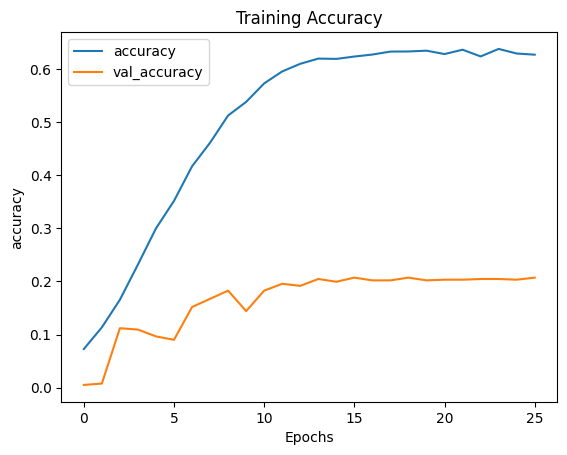

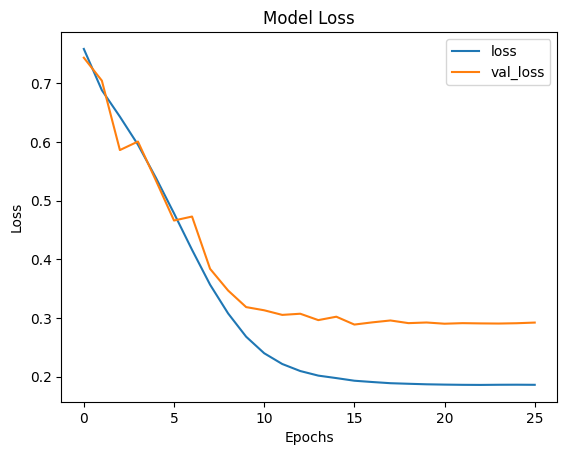

In [79]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [81]:
model.save_weights('model_weights.h5')

In [71]:
# import shutil

# folder_path = '/kaggle/working/my_model'

# # Specify the name of the zip file
# zip_filename = '/kaggle/working/my_model.zip'

# # Create the zip file
# shutil.make_archive(zip_filename, 'zip', folder_path)


# **Predict**

In [82]:
def convert_to_sequences(text):
    sequences_vec = tok.texts_to_sequences(text)
    sequences_matrix = pad_sequences(sequences_vec, maxlen = max_len, padding= 'post')
    return sequences_matrix

In [89]:
vector = convert_to_sequences(movies_test['title'])
vector

array([[   1,   73,  407, ...,    0,    0,    0],
       [2661,    0,    0, ...,    0,    0,    0],
       [ 123,    1,  196, ...,    0,    0,    0],
       ...,
       [   4, 2773,    2, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 396,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [90]:
predict = model.predict(vector)
predict

25/25 [==============================] - 0s 4ms/step


array([[0.2247349 , 0.4528231 , 0.09733557, ..., 0.22733045, 0.30251664,
        0.49764508],
       [0.05185071, 0.10316881, 0.10461207, ..., 0.09188045, 0.12664619,
        0.0894284 ],
       [0.00940213, 0.04622452, 0.05481295, ..., 0.01357638, 0.01680447,
        0.12609085],
       ...,
       [0.08387706, 0.09899949, 0.12373387, ..., 0.08876161, 0.14200474,
        0.32945457],
       [0.11013412, 0.23951542, 0.09282117, ..., 0.13657427, 0.17667569,
        0.09315079],
       [0.05037041, 0.06829797, 0.1193836 , ..., 0.06553146, 0.08866112,
        0.29642335]], dtype=float32)

In [91]:
y_pred = (predict > 0.5).astype(int)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [93]:
labels = [[idx2genre[i] for i, value in enumerate(row) if value == 1] for row in y_pred]
# labels

In [94]:
movies_test['predict_label'] = labels
movies_test['predict_vecto'] = predict.tolist()
movies_test

,movieid,title,genre,vecto,predict_label,predict_vecto
0,3397,The Great Muppet Cape,"[Children's, Comedy]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",[Musical],"[0.22473490238189697, 0.45282310247421265, 0.0..."
1,2067,Doctor Zhivag,"[Drama, Romance, War]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[0.051850706338882446, 0.10316880792379379, 0...."
2,2651,Frankenstein Meets the Wolf Ma,[Horror],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Horror],"[0.009402133524417877, 0.04622451588511467, 0...."
3,2989,For Your Eyes Onl,[Action],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Thriller],"[0.10736725479364395, 0.5611024498939514, 0.10..."
4,3415,The Mirro,[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[0.08749677240848541, 0.2059771716594696, 0.07..."
...,...,...,...,...,...,...
772,2309,The Inheritor,[Drama],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[0.08749686926603317, 0.20597714185714722, 0.0..."
773,2421,Part II Karate Ki,"[Action, Adventure, Drama]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",[],"[0.06410698592662811, 0.06149344518780708, 0.0..."
774,3255,A League of Their Ow,"[Comedy, Drama]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",[Comedy],"[0.0838770642876625, 0.09899948537349701, 0.12..."
775,974,Algier,"[Drama, Romance]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[0.11013411730527878, 0.23951542377471924, 0.0..."


In [105]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def onehot_mapk(targets, outputs, k):
    '''
    input:
    targets: true label ([0, 1, 0, 1, 1,...])
    outputs: predicted label ([0.12, 0.3, 0.51, 0.7, ...])
    k: number of top predictions that will take
    
    return: mapk score
    '''
    
    sorted_prediction_ids = np.argsort(-np.array(outputs),axis=1) #descending sort
    top_k_prediction_ids = sorted_prediction_ids[:,:k]
    
    # get all true label
    true_label_list = [ np.where(np.isclose(row, 1.0))[0].tolist() for row in targets]
    
    return mapk(true_label_list, top_k_prediction_ids)


In [106]:
outputs, targets = movies_test['predict_vecto'].values.tolist(), movies_test['vecto'].values.tolist()
mapk = onehot_mapk(targets, outputs, k = 5)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"Map@K Score = {mapk}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.03474903474903475
Map@K Score = 0.33233447733447735
F1 Score (Micro) = 0.11846689895470384
F1 Score (Macro) = 0.07908673187037023
